In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as th
# import torchmetrics as thm
import LPGNN
import igraph as ig
import networkx as nx
import torch_geometric as pyg

import pyarrow as pa
import pyarrow.parquet as pq

import importlib
import powerlaw

from tqdm import tqdm

/home/mf/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-16 18:13:49.573667: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-16 18:13:49.573696: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
importlib.reload(LPGNN.popularity_similarity)
importlib.reload(LPGNN.embedding)
importlib.reload(LPGNN.poincare_embedding)
importlib.reload(LPGNN.distances)
importlib.reload(LPGNN.visualization.degree_distribution)
importlib.reload(LPGNN.visualization)
importlib.reload(LPGNN.utils)
importlib.reload(LPGNN.labne)
importlib.reload(LPGNN.graph_metrics)
importlib.reload(LPGNN.DataSetup)
importlib.reload(LPGNN.LinkPrediction)

<module 'LPGNN.LinkPrediction' from '/home/mf/Documents/IB/Tesis/Maestria/LPGNN/LPGNN/LinkPrediction.py'>

In [2]:
seed = 50

In [3]:
N = 500
avg_k = 40
gamma = 2.4
T = 0.0
seed += 1
PS = LPGNN.popularity_similarity.generatePSNetwork(N, avg_k, gamma, T, seed, dim=2)

In [4]:
PS = LPGNN.DataSetup.train_test_split(PS, test_ratio=0.5, val_ratio=0, neg_samples=False)
#PS_LaBNE = LPGNN.labne.generateLaBNE(PS, normalize_radius=False)
PS_nx = nx.Graph(nx.from_edgelist(PS.train_pos_edge_label_index.T.detach().numpy()))
print("Train set connected: ", nx.is_connected(PS_nx))

Train set connected:  True


In [7]:
PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=False)
R_LaBNE_hyp, P_LaBNE_hyp = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_{N}_{avg_k}_{gamma}_{T}_{seed}_hyp', chunk_size=10000, skip_file_prep=False, step_size=100, dist='hyp')
R_LaBNE_poi, P_LaBNE_poi = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_{N}_{avg_k}_{gamma}_{T}_{seed}_poincare', chunk_size=10000, skip_file_prep=False, step_size=100, dist='poincare')

PS_LaBNE = LPGNN.labne.generateLaBNE(PS, edge_index='train_pos_edge_label_index', normalize_radius=0.9999999)
R_LaBNE_hyp_norm, P_LaBNE_hyp_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_{N}_{avg_k}_{gamma}_{T}_{seed}_hyp_norm', chunk_size=10000, skip_file_prep=False, step_size=100, dist='hyp')
R_LaBNE_poi_norm, P_LaBNE_poi_norm = LPGNN.LinkPrediction.precision_recall_score_file(PS_LaBNE, position_name='LaBNE_node_polar_positions', filename=f'data/Distance_Lists/Floating_point_precision/PS_LaBNE_{N}_{avg_k}_{gamma}_{T}_{seed}_poincare_norm', chunk_size=10000, skip_file_prep=False, step_size=100, dist='poincare')

Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/Floating_point_precision/PS_LaBNE_500_40_2.4_0.0_51_hyp
Sorting file...
Reading file and generating precision-recall curve...
index: 124600, R: 1.000, P: 0.039Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/Floating_point_precision/PS_LaBNE_500_40_2.4_0.0_51_poincare
Sorting file...
Reading file and generating precision-recall curve...
index: 124700, R: 1.000, P: 0.039Calculating best minimal value for power law fit
Generating test mask...
Total test mask:  tensor(4895.)  . Total test edges:  4895
Generating hyperbolic distances and saving to file  data/Distance_Lists/Floating_point_precision/PS_LaBNE_500_40_2.4_0.0_51_hyp_norm
Sorting file...
Reading file and generating precision

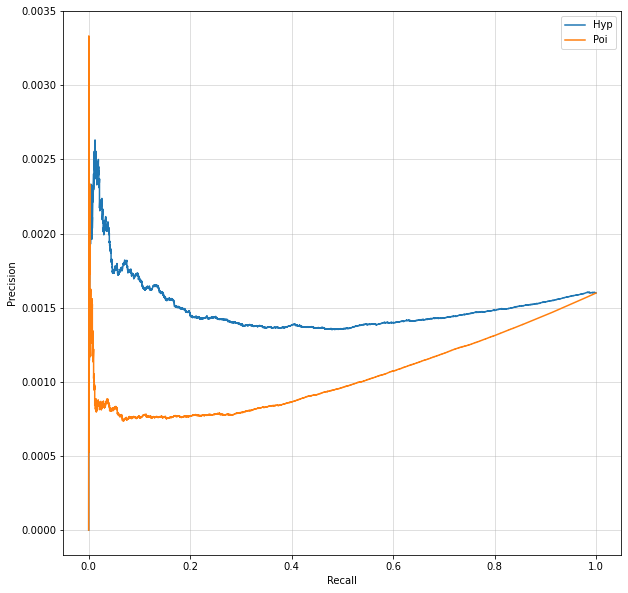

In [143]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')

ax.legend()

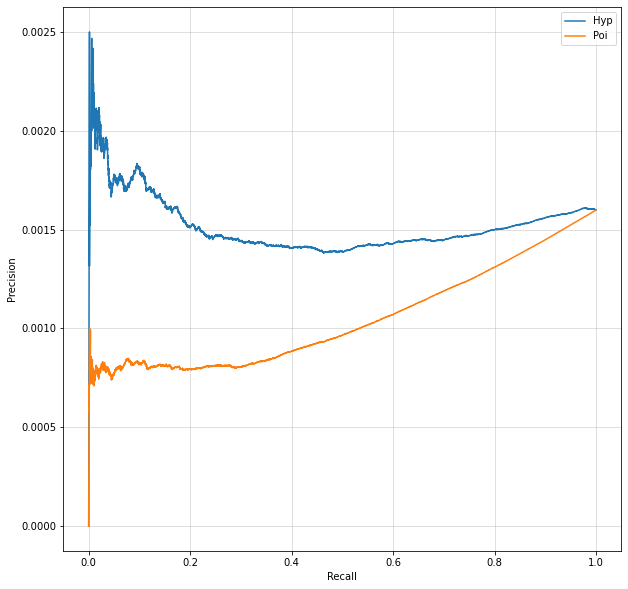

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')

ax.legend()

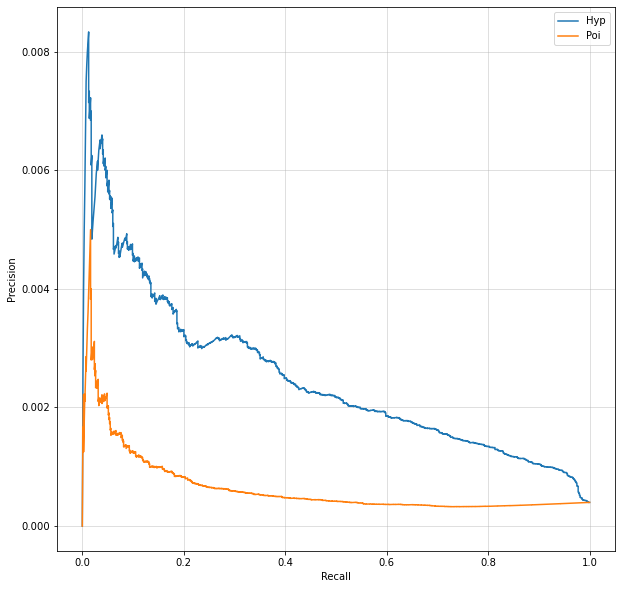

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')

ax.legend()

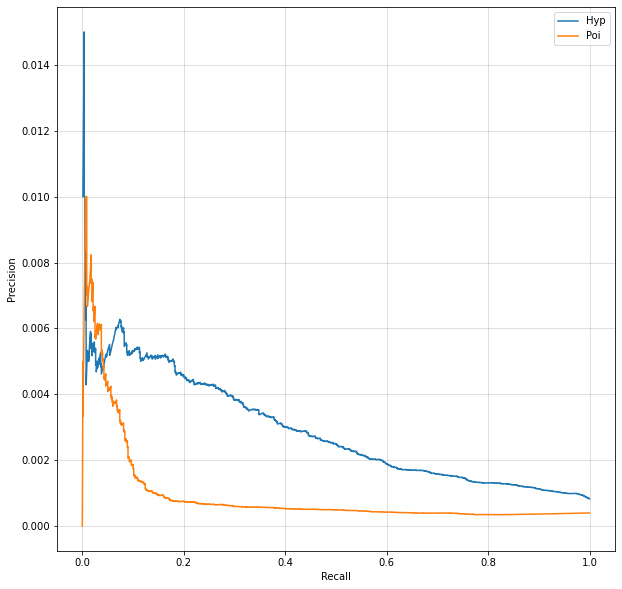

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')

ax.legend()

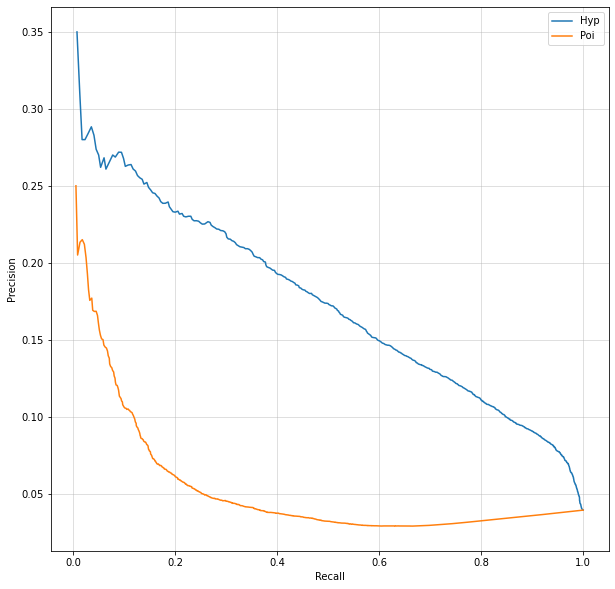

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')

ax.legend()

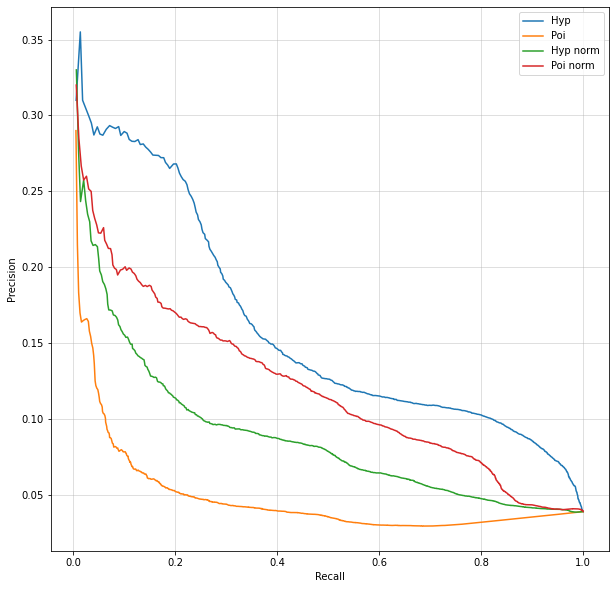

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.grid(alpha=0.5)

ax.plot(R_LaBNE_hyp, P_LaBNE_hyp, label='Hyp')
ax.plot(R_LaBNE_poi, P_LaBNE_poi, label='Poi')
ax.plot(R_LaBNE_hyp_norm, P_LaBNE_hyp_norm, label='Hyp norm')
ax.plot(R_LaBNE_poi_norm, P_LaBNE_poi_norm, label='Poi norm')

ax.legend()

In [112]:
def hyperbolic_distance(u:th.Tensor, v:th.Tensor):
    """ Calculates hyperbolic distances between positions given as a list of [r, theta] values.
        Uses idx to indicate which positions to compare.

    Args:
        positions (th.Tensor): A list of [r,theta] values
        idx (th.Tensor): A tensor of shape [N,2] indicating the combination of positions to compare.

    Returns:
        th.Tensor: A 1D tensor of hyperbolic distances of length N.
    """

    # ensure u,v type is double
    u = u.double()
    v = v.double()

    # get the angular distance by applying acos() to the dot product of the two vectors
    r_u = th.norm(u, dim=-1)
    z_u = -(r_u+1)/(r_u-1)
    r_v = th.norm(v, dim=-1)
    z_v = -(r_v+1)/(r_v-1)
    
    # convert to hyperboloid coordinates
    y_u = (1+z_u)*u
    y_v = (1+z_v)*v
    r_u = th.norm(y_u, dim=-1)
    r_v = th.norm(y_v, dim=-1)

    dot = th.sum(y_u * y_v, dim=1)
    angular_distance = th.acos(dot / (r_u * r_v))
    #angular_distance = th.min(2*th.pi-th.abs(u[:,1]-v[:,1]), th.abs(u[:,1]-v[:,1]))

    d = th.arccosh(th.cosh(r_u)*th.cosh(r_v) - th.sinh(r_u)*th.sinh(r_v)*th.cos(angular_distance))

    print(z_u, y_u)
    print(z_v, y_v)
    # now get it as the hyperboloid model distance
    d_h = th.arccosh(z_u*z_v - th.sum(y_u*y_v, dim=1))

    return d, d_h

In [113]:
u = th.Tensor([[0.9999999, 0.0]])
v = th.Tensor([[-0.9999999, 0]])

x = th.Tensor([[0.1, 0.5]])
y = th.Tensor([[0.2, 0.1]])

d_uv, dh_uv = hyperbolic_distance(u, v)
#d_xy, dh_xy = hyperbolic_distance(x, y)

dp_uv = LPGNN.distances.poincare_distance(u, v)
#dp_xy = LPGNN.distances.poincare_distance(x, y)

tensor([16777215.], dtype=torch.float64) tensor([[16777214.,        0.]], dtype=torch.float64)
tensor([16777215.], dtype=torch.float64) tensor([[-16777214.,         0.]], dtype=torch.float64)


In [110]:
dh_uv, dp_uv

(tensor([34.6574], dtype=torch.float64),
 tensor([33.2711], dtype=torch.float64))

In [148]:
a = 1.9999999 * 2**127
h_u = th.Tensor([[a, a-1, 0]]).double()
h_v = th.Tensor([[a, -a+1, 0]]).double()

th.arccosh(h_u[0]*h_v[0] - th.sum(h_u*h_v, dim=1))

tensor([178.1388,      nan,      nan], dtype=torch.float64)

In [149]:
a

3.402823499068201e+38

In [150]:
2**128

340282366920938463463374607431768211456